# Import Requirements

In [1]:
import spacy
from spacy.training.example import Example
from spacy.util import minibatch, compounding
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# --- CONFIGURATION ---
EPOCHS = 30                # Number of training loops
BATCH_SIZE = 8             # Process 8 sentences at a time
DROPOUT = 0.5              # Randomness to prevent overfitting
MODEL_NAME = "en_core_web_md" # The base model we are fine-tuning

# 1. LOAD THE DATA

In [3]:
# We load the JSON file generated in the training_data.py
print("Loading dataset...")
try:
    with open("train_financial_ner.json", "r") as f:
        TRAIN_DATA = json.load(f)
    print(f"Loaded {len(TRAIN_DATA)} training examples.")
except FileNotFoundError:
    print("Error: 'train_financial_ner.json' not found. Please run the Data Generation script first!")
    exit()

Loading dataset...
Loaded 264 training examples.


## Dataset Statistics and Visualizations

Total number of texts: 264
Total number of entities: 818
Unique entity types: 9

Entity type distribution:
  ORG: 349
  MONEY: 97
  DATE: 87
  PERCENT: 65
  TICKER: 62
  PER: 51
  ROLE: 40
  INDICATOR: 35
  EVENT: 32


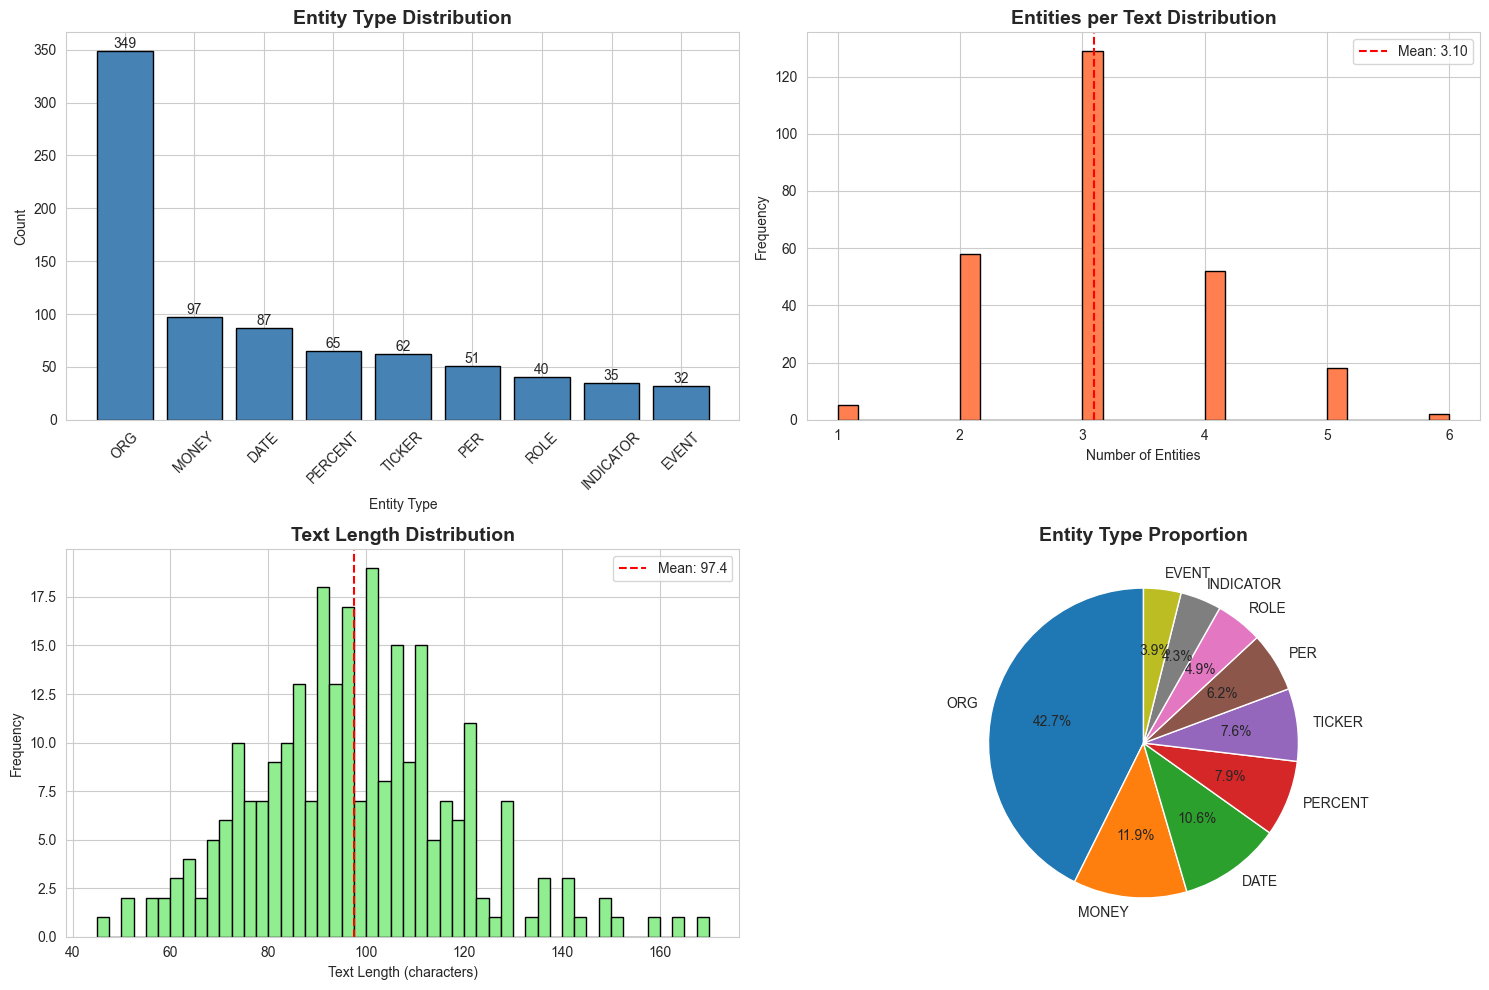


📊 Average entities per text: 3.10
📊 Average text length: 97.4 characters


In [4]:
# Analyze entity distribution
entity_labels = []
text_lengths = []
entity_counts_per_text = []

for text, annotations in TRAIN_DATA:
    entities = annotations.get("entities", [])
    entity_counts_per_text.append(len(entities))
    text_lengths.append(len(text))
    for ent in entities:
        entity_labels.append(ent[2])

# Count entity types
label_counts = Counter(entity_labels)

print(f"Total number of texts: {len(TRAIN_DATA)}")
print(f"Total number of entities: {len(entity_labels)}")
print(f"Unique entity types: {len(label_counts)}")
print(f"\nEntity type distribution:")
for label, count in label_counts.most_common():
    print(f"  {label}: {count}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Entity type distribution (bar chart)
labels, counts = zip(*label_counts.most_common())
axes[0, 0].bar(labels, counts, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Entity Type Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Entity Type')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, count in enumerate(counts):
    axes[0, 0].text(i, count, str(count), ha='center', va='bottom')

# 2. Entities per text distribution
axes[0, 1].hist(entity_counts_per_text, bins=30, color='coral', edgecolor='black')
axes[0, 1].set_title('Entities per Text Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Entities')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(np.mean(entity_counts_per_text), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(entity_counts_per_text):.2f}')
axes[0, 1].legend()

# 3. Text length distribution
axes[1, 0].hist(text_lengths, bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Text Length Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Text Length (characters)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(np.mean(text_lengths), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(text_lengths):.1f}')
axes[1, 0].legend()

# 4. Entity type proportion (pie chart)
axes[1, 1].pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Entity Type Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Average entities per text: {np.mean(entity_counts_per_text):.2f}")
print(f"📊 Average text length: {np.mean(text_lengths):.1f} characters")

# 2. LOAD THE BASE MODEL

In [5]:
# We load the medium English model (must install first: python -m spacy download en_core_web_md)
nlp = spacy.load(MODEL_NAME)

# 3. SETUP THE PIPELINE

In [6]:
# Check if NER pipe exists, if not add it
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# 4. ADD NEW LABELS

In [7]:
# The video loops through data to find labels. We do the same.
print("Adding labels to model...")
for _, annotations in TRAIN_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

Adding labels to model...


# 5. DISABLE OTHER PIPELINES

In [8]:
# We only want to train NER, not the tagger or parser
pipe_exceptions = ["ner", "trf_tok2vec", "tok2vec"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# 6. TRAINING LOOP

In [9]:
print(f"Starting training for {EPOCHS} epochs...")

# Track losses for visualization
epoch_losses = []

with nlp.disable_pipes(*other_pipes):
    
    # Initialize optimizer
    optimizer = nlp.create_optimizer()
    
    for epoch in range(EPOCHS):
        random.shuffle(TRAIN_DATA)
        losses = {}
        
        # Create batches
        # We use compounding to start with small batches and increase them
        batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
        
        for batch in batches:
            texts, annotations = zip(*batch)
            
            # Convert to spaCy 'Example' objects (Required for spaCy v3)
            examples = []
            for i in range(len(texts)):
                doc = nlp.make_doc(texts[i])
                example = Example.from_dict(doc, annotations[i])
                examples.append(example)
            
            # Update the model
            nlp.update(
                examples,
                drop=DROPOUT,
                losses=losses,
                sgd=optimizer
            )
        
        epoch_losses.append(losses['ner'])
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {losses['ner']:.2f}")

print("\n✅ Training completed!")

Starting training for 30 epochs...
Epoch 1/30 - Loss: 881.57
Epoch 1/30 - Loss: 881.57
Epoch 2/30 - Loss: 690.66
Epoch 2/30 - Loss: 690.66
Epoch 3/30 - Loss: 528.81
Epoch 3/30 - Loss: 528.81
Epoch 4/30 - Loss: 477.50
Epoch 4/30 - Loss: 477.50
Epoch 5/30 - Loss: 416.41
Epoch 5/30 - Loss: 416.41
Epoch 6/30 - Loss: 374.66
Epoch 6/30 - Loss: 374.66
Epoch 7/30 - Loss: 422.25
Epoch 7/30 - Loss: 422.25
Epoch 8/30 - Loss: 326.11
Epoch 8/30 - Loss: 326.11
Epoch 9/30 - Loss: 307.83
Epoch 9/30 - Loss: 307.83
Epoch 10/30 - Loss: 327.38
Epoch 10/30 - Loss: 327.38
Epoch 11/30 - Loss: 294.57
Epoch 11/30 - Loss: 294.57
Epoch 12/30 - Loss: 255.81
Epoch 12/30 - Loss: 255.81
Epoch 13/30 - Loss: 286.83
Epoch 13/30 - Loss: 286.83
Epoch 14/30 - Loss: 254.38
Epoch 14/30 - Loss: 254.38
Epoch 15/30 - Loss: 222.80
Epoch 15/30 - Loss: 222.80
Epoch 16/30 - Loss: 226.62
Epoch 16/30 - Loss: 226.62
Epoch 17/30 - Loss: 210.10
Epoch 17/30 - Loss: 210.10
Epoch 18/30 - Loss: 221.81
Epoch 18/30 - Loss: 221.81
Epoch 19/30

## Training Loss Visualization

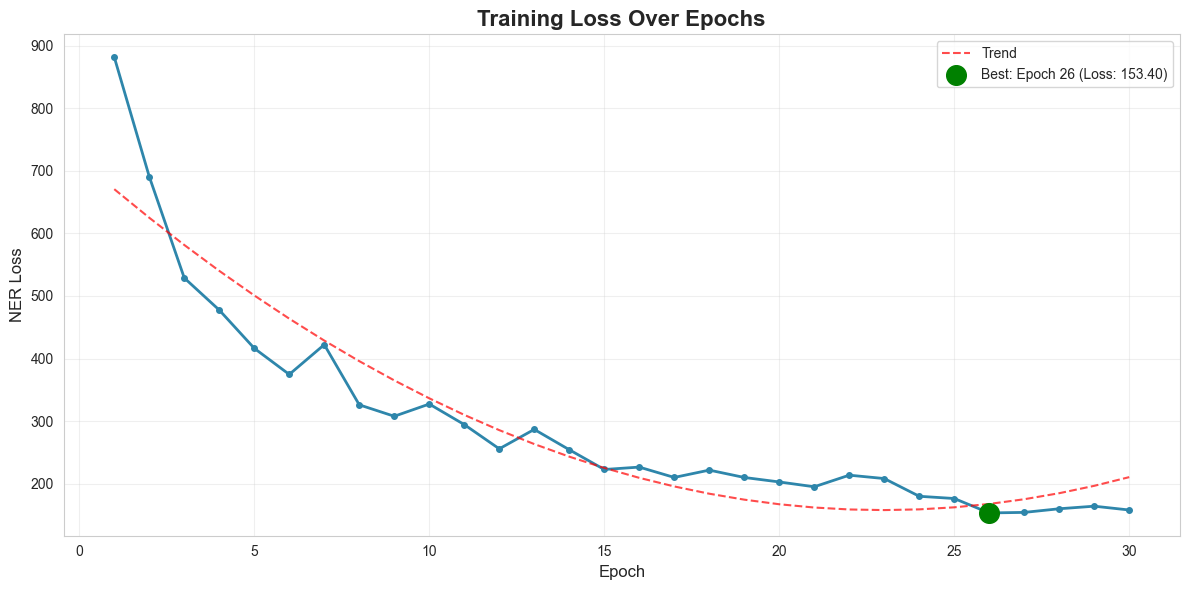


📉 Initial Loss: 881.57
📉 Final Loss: 158.08
📉 Loss Reduction: 82.1%
🏆 Best Loss: 153.40 at Epoch 26


In [10]:
# Plot training loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCHS + 1), epoch_losses, marker='o', linewidth=2, markersize=4, color='#2E86AB')
plt.title('Training Loss Over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('NER Loss', fontsize=12)
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(range(1, EPOCHS + 1), epoch_losses, 2)
p = np.poly1d(z)
plt.plot(range(1, EPOCHS + 1), p(range(1, EPOCHS + 1)), 
         linestyle='--', color='red', alpha=0.7, label='Trend')

# Highlight best epoch
best_epoch = np.argmin(epoch_losses) + 1
best_loss = min(epoch_losses)
plt.scatter([best_epoch], [best_loss], color='green', s=200, zorder=5, 
            label=f'Best: Epoch {best_epoch} (Loss: {best_loss:.2f})')

plt.legend()
plt.tight_layout()
plt.show()

print(f"\n📉 Initial Loss: {epoch_losses[0]:.2f}")
print(f"📉 Final Loss: {epoch_losses[-1]:.2f}")
print(f"📉 Loss Reduction: {((epoch_losses[0] - epoch_losses[-1]) / epoch_losses[0] * 100):.1f}%")
print(f"🏆 Best Loss: {best_loss:.2f} at Epoch {best_epoch}")

# 7. SAVE THE MODEL

In [9]:
output_dir = "financial_ner_model"
nlp.to_disk(output_dir)
print(f"\nModel saved to directory: {output_dir}")


Model saved to directory: financial_ner_model


# 8. TEST THE MODEL (Immediate Sanity Check)

In [11]:
print("\n--- TESTING THE NEW MODEL ---")
test_sentences = [
    "Apple (AAPL) announced the acquisition of an AI startup for $50 million.",
    "The CPI rose 0.4% in March, signaling inflation.",
    "Nvidia announced a stock split after hitting $900."
]

for text in test_sentences:
    doc = nlp(text)
    print(f"\nText: {text}")
    for ent in doc.ents:
        print(f"  {ent.text} -> {ent.label_}")


--- TESTING THE NEW MODEL ---

Text: Apple (AAPL) announced the acquisition of an AI startup for $50 million.
  Apple -> ORG
  AAPL -> TICKER
  acquisition -> EVENT
  $50 million -> MONEY

Text: The CPI rose 0.4% in March, signaling inflation.
  0.4% -> PERCENT
  March -> DATE

Text: Nvidia announced a stock split after hitting $900.
  Nvidia -> ORG
  stock split -> EVENT
  $900 -> MONEY


## Entity Recognition Visualization

In [12]:
# Visualize entity predictions
from IPython.display import HTML

def visualize_entities(doc):
    """Create a colored visualization of entities in text"""
    colors = {
        'ORG': '#7aecec',
        'PERSON': '#aa9cfc',
        'GPE': '#feca74',
        'DATE': '#9cc9cc',
        'MONEY': '#e4e7d2',
        'PERCENT': '#f0d0ff',
        'TICKER': '#ff9561',
        'PRODUCT': '#bfe1d9',
        'EVENT': '#ffeb9c',
        'CARDINAL': '#ddd'
    }
    
    html = '<div style="line-height: 2.5; font-size: 16px;">'
    last_idx = 0
    
    for ent in doc.ents:
        # Add text before entity
        html += doc.text[last_idx:ent.start_char]
        # Add entity with color
        color = colors.get(ent.label_, '#ddd')
        html += f'<span style="background-color: {color}; padding: 2px 6px; border-radius: 3px; margin: 2px;">'
        html += f'{ent.text} <span style="font-size: 12px; font-weight: bold;">({ent.label_})</span></span>'
        last_idx = ent.end_char
    
    html += doc.text[last_idx:]
    html += '</div>'
    return HTML(html)

print("🎨 Visualizing Entity Recognition:\n")
for text in test_sentences:
    doc = nlp(text)
    display(visualize_entities(doc))
    print()

🎨 Visualizing Entity Recognition:



# Model Evaluation

In [13]:
!python evaluate_model.py

Loading model from: financial_ner_model...
Loading validation data from: dev_financial_ner.json...
Evaluating on 66 examples...

METRIC          | SCORE     
Precision       | 94.26%
Recall          | 95.63%
F1-Score        | 94.94%

Breakdown by Entity Type:
ENTITY       | PRECISION  | RECALL     | F1        
------------------------------------------------
DATE         | 100.00%    | 100.00%    | 100.00%
EVENT        | 71.43%    | 100.00%    | 83.33%
INDICATOR    | 76.92%    | 83.33%    | 80.00%
MONEY        | 100.00%    | 100.00%    | 100.00%
ORG          | 94.57%    | 96.67%    | 95.60%
PER          | 85.71%    | 100.00%    | 92.31%
PERCENT      | 100.00%    | 100.00%    | 100.00%
ROLE         | 100.00%    | 100.00%    | 100.00%
TICKER       | 100.00%    | 75.00%    | 85.71%


# Update Training Data

In [14]:
!python update_dataset.py

Loaded 264 existing examples.
Success! Added 30 new repair examples.
Total Training Dataset Size: 294


# Evaluate model after updating Training Data

In [15]:
!python evaluate_model.py

Loading model from: financial_ner_model...
Loading validation data from: dev_financial_ner.json...
Evaluating on 66 examples...

METRIC          | SCORE     
Precision       | 94.26%
Recall          | 95.63%
F1-Score        | 94.94%

Breakdown by Entity Type:
ENTITY       | PRECISION  | RECALL     | F1        
------------------------------------------------
DATE         | 100.00%    | 100.00%    | 100.00%
EVENT        | 71.43%    | 100.00%    | 83.33%
INDICATOR    | 76.92%    | 83.33%    | 80.00%
MONEY        | 100.00%    | 100.00%    | 100.00%
ORG          | 94.57%    | 96.67%    | 95.60%
PER          | 85.71%    | 100.00%    | 92.31%
PERCENT      | 100.00%    | 100.00%    | 100.00%
ROLE         | 100.00%    | 100.00%    | 100.00%
TICKER       | 100.00%    | 75.00%    | 85.71%


# Update Validation Data

In [16]:
!python update_dev.py

Loaded 66 existing Dev examples.
Success! Added 15 new examples to the Dev Set.
New Dev Set Size: 81


# Evaluate on updated Validation Data

In [17]:
!python evaluate_model.py

Loading model from: financial_ner_model...
Loading validation data from: dev_financial_ner.json...
Evaluating on 81 examples...

METRIC          | SCORE     
Precision       | 90.00%
Recall          | 93.91%
F1-Score        | 91.91%

Breakdown by Entity Type:
ENTITY       | PRECISION  | RECALL     | F1        
------------------------------------------------
DATE         | 94.44%    | 100.00%    | 97.14%
EVENT        | 78.57%    | 84.62%    | 81.48%
INDICATOR    | 73.68%    | 73.68%    | 73.68%
MONEY        | 91.43%    | 100.00%    | 95.52%
ORG          | 94.12%    | 96.97%    | 95.52%
PER          | 85.71%    | 100.00%    | 92.31%
PERCENT      | 76.47%    | 100.00%    | 86.67%
ROLE         | 100.00%    | 100.00%    | 100.00%
TICKER       | 100.00%    | 75.00%    | 85.71%


# Model is Ready to use!! 🎉🗿